# Unsupervised Learning and Dimensionality Reduction

Things to do:
 - Rerun the Neural Network on the Adult Data using all samples and a scaler
 - Run k-means and EM algorithms on the scaled Adult Data. Describe what you see
 - Run PCA, ICA, and Randomized Projects on the scaled adult data. Describe what you see.
 - Rerun k-means and EM on the data after it has been run through each dimensionality reduction algorithm
 - Rerun Neural Network on dimensionality reduced Adult Data
 - Rerun Neural Network on clustered data (use clusters as features)

# Load in Adult Data and Preprocess

In [10]:
%matplotlib inline

import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
from sklearn.manifold import TSNE

In [11]:
train = pd.read_csv('adult_train.csv')
test = pd.read_csv('adult_test.csv')
test["income"] = test.income.apply(lambda x: x[:-1])
adult_data = pd.concat([train, test])
adult_data = adult_data.sample(n=6000)

In [12]:
categorical_columns = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "sex", "native_country", "income"]

adult_data = pd.get_dummies(adult_data, columns=categorical_columns)

In [13]:
y = adult_data["income_ >50K"]
X = adult_data.drop(["income_ >50K", "income_ <=50K"], axis=1)
X_columns = X.columns

In [14]:
y_train, y_test = train_test_split(y, test_size=0.1, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, stratify=y, random_state=42)

In [15]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("random_forest", RandomForestClassifier(random_state=1))
])

rf = rf_pipeline.fit(X_train, y_train)
feature_importances = rf.named_steps["random_forest"].feature_importances_
features_df = pd.DataFrame({"feature" : X_train.columns, "importance" : feature_importances})
features_df = features_df.sort_values(by = "importance",
                                      ascending=False).reset_index(drop=True)

features_df.to_csv("feature_importances_adult.csv")
columns_to_keep = list(features_df.iloc[:50, :].feature)

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.loc[:, columns_to_keep])
X_test = scaler.transform(X_test.loc[:, columns_to_keep])

# Run on a Neural Net

In [ ]:
clf = MLPClassifier(max_iter=1000)

parameters = {
    'hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

gs_results = pd.DataFrame(grid_search.cv_results_)
gs_results.to_csv("nn_baseline_adult.csv")

In [10]:
clf = MLPClassifier(max_iter=1000)

parameters = {
    'hidden_layer_sizes' : [tuple([x]) for x in range(5, 100, 5)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

gs_results = pd.DataFrame(grid_search.cv_results_)
gs_results.to_csv("nn_baseline_2_adult.csv")

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

I performed a grid search on the standardized data, first testing one to five hidden layers of 10 to 100 nodes each. The search found that a single layer of 10 was the optimum, but only by a small amount. The second grid search tested a single hidden layer with one to twenty nodes. Above 3 nodes, all cross validation scores were within a fraction of a percent of each other. All neural nets in this experiment moving forward used a single hidden layer of 5 nodes.

In [9]:
gs_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_hidden_layer_sizes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.618144,0.195177,0.001354,0.000304,"(5,)","{'hidden_layer_sizes': (5,)}",0.841035,0.841035,0.835490,0.833333,...,0.857584,0.862551,0.859259,0.864198,0.863374,0.861345,0.859288,0.858671,0.860864,0.002033
1,2.765926,0.492521,0.000800,0.000022,"(10,)","{'hidden_layer_sizes': (10,)}",0.839187,0.848429,0.829945,0.829630,...,0.872608,0.875720,0.872634,0.859259,0.868930,0.872043,0.872454,0.881094,0.871481,0.005310
2,3.305237,0.538553,0.000856,0.000038,"(15,)","{'hidden_layer_sizes': (15,)}",0.850277,0.846580,0.837338,0.825926,...,0.883927,0.883539,0.885597,0.878189,0.883128,0.886237,0.875746,0.883974,0.881584,0.003626
3,3.785197,0.702566,0.004196,0.009005,"(20,)","{'hidden_layer_sizes': (20,)}",0.833641,0.839187,0.835490,0.840741,...,0.888660,0.890123,0.891152,0.879424,0.890741,0.896112,0.897141,0.897141,0.892572,0.005588
4,4.032211,0.570168,0.001358,0.000328,"(25,)","{'hidden_layer_sizes': (25,)}",0.837338,0.824399,0.844732,0.809259,...,0.887837,0.905761,0.897737,0.897119,0.906790,0.897346,0.903312,0.902695,0.899506,0.005558
5,6.440751,1.064334,0.001477,0.000151,"(30,)","{'hidden_layer_sizes': (30,)}",0.844732,0.848429,0.835490,0.824074,...,0.895452,0.904527,0.911728,0.901440,0.902675,0.899609,0.904958,0.901666,0.903827,0.004545
6,6.556174,1.375037,0.001523,0.000184,"(35,)","{'hidden_layer_sizes': (35,)}",0.831793,0.846580,0.835490,0.818519,...,0.897921,0.897119,0.914609,0.903086,0.904115,0.915449,0.914009,0.908044,0.907222,0.007049
7,6.703791,1.237726,0.001574,0.000151,"(40,)","{'hidden_layer_sizes': (40,)}",0.833641,0.835490,0.837338,0.811111,...,0.905742,0.911934,0.905556,0.919342,0.912346,0.904752,0.907632,0.912158,0.911091,0.004989
8,6.840209,1.053598,0.001669,0.000195,"(45,)","{'hidden_layer_sizes': (45,)}",0.833641,0.857671,0.839187,0.807407,...,0.909035,0.904527,0.919136,0.912346,0.910494,0.919358,0.922238,0.915244,0.914876,0.005695
9,7.579405,1.482577,0.001583,0.000067,"(50,)","{'hidden_layer_sizes': (50,)}",0.839187,0.829945,0.828096,0.811111,...,0.922206,0.912963,0.925103,0.909053,0.914403,0.912158,0.918741,0.905781,0.916070,0.005955


In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(5))

base_cv = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10).mean()
base_cv

# Analysis Through K-Means

In [8]:
cluster_error = pd.DataFrame(columns=["k", "time", "avg_inertia",
                                      "homogeneity", "completeness",
                                      "v_measure", "adj_rand",
                                      "adj_mutual_info", "silhouette"])

kmeans = KMeans()

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]

for k in k_range:
    print(f"training {k}-means!")
    t0 = timeit.default_timer()
    kmeans = kmeans.set_params(n_clusters=k).fit(X_train)
    labels = kmeans.labels_
    scores = {"k": k,
              "time" : timeit.default_timer() - t0,
              "avg_inertia": kmeans.inertia_/len(X_train),
              "homogeneity": metrics.homogeneity_score(y_train, labels),
              "completeness" : metrics.completeness_score(y_train, labels),
              "v_measure" : metrics.v_measure_score(y_train, labels),
              "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
              "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
              "silhouette": metrics.silhouette_score(X_train, labels,
                                                    metric='euclidean',
                                                    sample_size=300)
             }
    cluster_error = cluster_error.append(scores, ignore_index=True)

all_cluster_errors = cluster_error.assign(model = "kmeans")

training 2-means!
training 5-means!
training 10-means!
training 15-means!
training 20-means!
training 25-means!
training 30-means!
training 40-means!
training 50-means!
training 100-means!


In [9]:
kmeans_labels = kmeans.set_params(n_clusters=2).fit(X_train).labels_

# Analysis Through EM

In [10]:
em_error = pd.DataFrame(columns=["k", "time", "lower_bound",
                                 "homogeneity", "completeness",
                                 "v_measure", "adj_rand",
                                  "adj_mutual_info", "BIC", "silhouette"])

em = GaussianMixture()

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]

for k in k_range:
    print(f"training {k}-means!")
    t0 = timeit.default_timer()
    em = em.set_params(n_components=k).fit(X_train)
    labels = em.predict(X_train)
    scores = {"k": k,
              "time" : timeit.default_timer() - t0,
              "lower_bound": em.lower_bound_,
              "homogeneity": metrics.homogeneity_score(y_train, labels),
              "completeness" : metrics.completeness_score(y_train, labels),
              "v_measure" : metrics.v_measure_score(y_train, labels),
              "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
              "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
              "BIC" : em.bic(X_train),
              "silhouette": metrics.silhouette_score(X_train, labels,
                                                    metric='euclidean',
                                                    sample_size=300)
             }
    em_error = em_error.append(scores, ignore_index=True)
    
all_cluster_errors = pd.concat([all_cluster_errors, em_error.assign(model = "em")], sort=True)
all_cluster_errors.to_csv("cluster_metrics_adult.csv")

training 2-means!
training 5-means!
training 10-means!
training 15-means!
training 20-means!
training 25-means!
training 30-means!
training 40-means!
training 50-means!
training 100-means!


In [11]:
em_labels = em.set_params(n_components=2).fit(X_train).predict(X_train)

# t-SNE Graph

In [12]:
perplexities = [2, 5, 10, 20, 30, 50, 100, 200]

X_tsne = pd.DataFrame(columns=["X1", "X2", "perplexity", "training_time"])
for perplexity in perplexities:
    tsne = TSNE(n_components=2, random_state=341, perplexity=perplexity)
    t0 = timeit.default_timer()
    temp = pd.DataFrame(tsne.fit_transform(X_train), columns=["X1", "X2"])
    temp = temp.assign(y = np.array(y_train),
                       kmeans_cluster = kmeans_labels,
                       em_cluster = em_labels,
                       perplexity=perplexity,
                       training_time = timeit.default_timer() - t0)
    X_tsne = pd.concat([X_tsne, temp], sort=True)

X_tsne.to_csv("tsne_clusters_adult.csv")

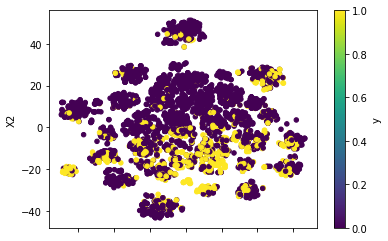

In [31]:
X_tsne[X_tsne.perplexity == 200].plot.scatter(x='X1', y='X2', c="y", colormap='viridis')

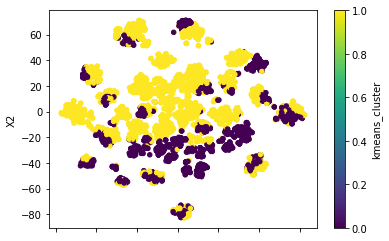

In [14]:
X_tsne[X_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="kmeans_cluster", colormap='viridis')

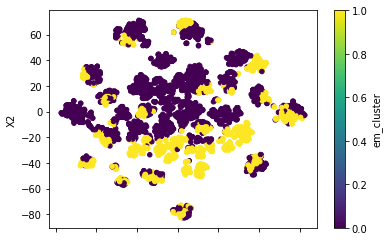

In [15]:
X_tsne[X_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="em_cluster", colormap='viridis')

# Principal Component Analysis

In [16]:
pca = PCA(random_state=2).fit(X_train)
pca_var = pd.DataFrame(pca.explained_variance_)
pca_var.to_csv("pca_explained_variance_adult.csv")

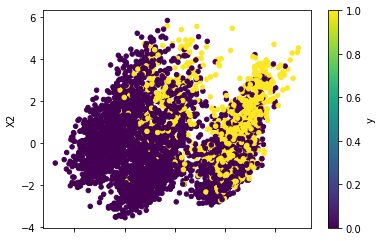

In [17]:
pca = PCA(random_state=2, n_components=2).fit_transform(X_train)
pca_df = pd.DataFrame(pca, columns=["X1","X2"]).assign(y = np.array(y_train), algorithm="pca")
pca_df.plot.scatter(x='X1', y='X2', c='y', colormap='viridis')

In [18]:
cluster_error = pd.DataFrame(columns=["k", "n", "without_labels_mean",
                                      "without_labels_sd", "with_labels_mean",
                                      "with_labels_sd",
                                      "time", "avg_inertia",
                                      "homogeneity", "completeness",
                                      "v_measure", "adj_rand",
                                      "adj_mutual_info", "silhouette"])

kmeans = KMeans()
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=2000)

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]
n_range = [2, 3, 4, 5, 10, 20, 30]

for i, n in enumerate(n_range):
    X_pca = PCA(random_state=i, n_components=n).fit_transform(X_train)
    for j, k in enumerate(k_range):
        # print(f"training {k}-means!")
        t0 = timeit.default_timer()
        kmeans = kmeans.set_params(n_clusters=k).fit(X_pca)
        labels = kmeans.labels_
        wo_labels_cv = cross_val_score(clf, X_pca, y_train)
        w_labels_cv = cross_val_score(clf,
                                      pd.DataFrame(X_pca).assign(labels=labels),
                                      y_train)
        
        scores = {"k": k,
                  "n": n,
                  "without_labels_mean": np.mean(wo_labels_cv),
                  "without_labels_sd": np.std(wo_labels_cv),
                  "with_labels_mean" : np.mean(w_labels_cv),
                  "with_labels_sd" : np.std(w_labels_cv),
                  "time" : timeit.default_timer() - t0,
                  "avg_inertia": kmeans.inertia_/len(X_train),
                  "homogeneity": metrics.homogeneity_score(y_train, labels),
                  "completeness" : metrics.completeness_score(y_train, labels),
                  "v_measure" : metrics.v_measure_score(y_train, labels),
                  "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
                  "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
                  "silhouette": metrics.silhouette_score(X_pca, labels,
                                                        metric='euclidean',
                                                        sample_size=300)
                 }
        cluster_error = cluster_error.append(scores, ignore_index=True)

all_dr_errors = cluster_error.assign(algorithm = "pca", clusterer = "kmeans")

In [19]:
em_error = pd.DataFrame(columns=["k", "n", "time", "lower_bound",
                                 "without_labels_mean", "without_labels_sd",
                                 "with_labels_mean", "with_labels_sd",
                                 "homogeneity", "completeness",
                                 "v_measure", "adj_rand",
                                  "adj_mutual_info", "BIC", "silhouette"])

em = GaussianMixture()
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=2000)

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]
n_range = [2, 3, 4, 5, 10, 20, 30]

for i, n in enumerate(n_range):
    X_pca = PCA(random_state=i, n_components=n).fit_transform(X_train)
    for j, k in enumerate(k_range):
        t0 = timeit.default_timer()
        em = em.set_params(n_components=k).fit(X_pca)
        labels = em.predict(X_pca)
        wo_labels_cv = cross_val_score(clf, X_pca, y_train)
        w_labels_cv = cross_val_score(clf,
                                      pd.DataFrame(X_pca).assign(labels=labels),
                                      y_train)

        scores = {"k": k,
                  "n": n,
                  "without_labels_mean": np.mean(wo_labels_cv),
                  "without_labels_sd": np.std(wo_labels_cv),
                  "with_labels_mean" : np.mean(w_labels_cv),
                  "with_labels_sd" : np.std(w_labels_cv),
                  "time" : timeit.default_timer() - t0,
                  "lower_bound": em.lower_bound_,
                  "homogeneity": metrics.homogeneity_score(y_train, labels),
                  "completeness" : metrics.completeness_score(y_train, labels),
                  "v_measure" : metrics.v_measure_score(y_train, labels),
                  "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
                  "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
                  "BIC" : em.bic(X_pca),
                  "silhouette": metrics.silhouette_score(X_pca, labels,
                                                        metric='euclidean',
                                                        sample_size=300)
                 }
        em_error = em_error.append(scores, ignore_index=True)
    
all_dr_errors = pd.concat([em_error.assign(algorithm = "pca", clusterer = "em"),
                           all_dr_errors])

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



# Independent Component Analysis

In [20]:
n_components = [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]

kurtosis = {'n' : [], 'kurtosis': []}
for n in n_components:
    ica = FastICA(random_state=34, n_components=n).fit_transform(X_train)
    kurtosis['n'].append(n)
    kurtosis['kurtosis'].append(pd.DataFrame(ica).kurt().abs().mean())
    
kurtosis = pd.DataFrame(kurtosis)
kurtosis.to_csv("ica_kurtosis_adult.csv")
kurtosis

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


,n,kurtosis
0,2,0.794784
1,3,2.904177
2,4,2.471071
3,5,2.512358
4,10,3.792030
5,15,5.681673
6,20,8.014448
7,25,11.191920
8,30,13.820563
9,40,18.333966


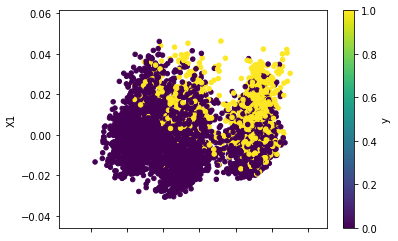

In [21]:
ica = FastICA(random_state=34, n_components=2).fit_transform(X_train)
ica = pd.DataFrame(ica, columns=["X1","X2"]).assign(y = np.array(y_train))
all_2d = pd.concat([pca_df, ica.assign(algorithm = "ica")])
ica.plot.scatter(x='X2', y='X1', c='y', colormap='viridis')

In [ ]:
ica = FastICA(random_state=34, n_components=40).fit_transform(X_train)

In [ ]:
perplexities = [2, 5, 10, 20, 30, 50, 100, 200]

X_ica_tsne = pd.DataFrame(columns=["X1", "X2", "perplexity", "training_time"])
for perplexity in perplexities:
    tsne = TSNE(n_components=2, random_state=341, perplexity=perplexity)
    t0 = timeit.default_timer()
    temp = pd.DataFrame(tsne.fit_transform(ica), columns=["X1", "X2"])
    temp = temp.assign(y = np.array(y_train),
                       kmeans_cluster = kmeans_labels,
                       em_cluster = em_labels,
                       perplexity=perplexity,
                       training_time = timeit.default_timer() - t0)
    X_ica_tsne = pd.concat([X_tsne, temp], sort=True)

X_ica_tsne.head()

In [ ]:
X_ica_tsne[X_ica_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="y", colormap='viridis')

In [22]:
cluster_error = pd.DataFrame(columns=["k", "n", "without_labels_mean",
                                      "without_labels_sd", "with_labels_mean",
                                      "with_labels_sd",
                                      "time", "avg_inertia",
                                      "homogeneity", "completeness",
                                      "v_measure", "adj_rand",
                                      "adj_mutual_info", "silhouette"])

kmeans = KMeans()
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=2000)

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]
n_range = [2, 3, 4, 5, 10, 20, 30]

for i, n in enumerate(n_range):
    X_ica = FastICA(random_state=i, n_components=n).fit_transform(X_train)
    for j, k in enumerate(k_range):
        # print(f"training {k}-means!")
        t0 = timeit.default_timer()
        kmeans = kmeans.set_params(n_clusters=k).fit(X_ica)
        labels = kmeans.labels_
        wo_labels_cv = cross_val_score(clf, X_ica, y_train)
        w_labels_cv = cross_val_score(clf,
                                      pd.DataFrame(X_ica).assign(labels=labels),
                                      y_train)
        
        scores = {"k": k,
                  "n": n,
                  "without_labels_mean": np.mean(wo_labels_cv),
                  "without_labels_sd": np.std(wo_labels_cv),
                  "with_labels_mean" : np.mean(w_labels_cv),
                  "with_labels_sd" : np.std(w_labels_cv),
                  "time" : timeit.default_timer() - t0,
                  "avg_inertia": kmeans.inertia_/len(X_train),
                  "homogeneity": metrics.homogeneity_score(y_train, labels),
                  "completeness" : metrics.completeness_score(y_train, labels),
                  "v_measure" : metrics.v_measure_score(y_train, labels),
                  "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
                  "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
                  "silhouette": metrics.silhouette_score(X_ica, labels,
                                                        metric='euclidean',
                                                        sample_size=300)
                 }
        cluster_error = cluster_error.append(scores, ignore_index=True)

all_dr_errors = pd.concat([cluster_error.assign(algorithm = "ica", clusterer = "kmeans"),
                           all_dr_errors])
cluster_error.sort_values(by = "adj_rand", ascending=False).head()

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,k,n,without_labels_mean,without_labels_sd,with_labels_mean,with_labels_sd,time,avg_inertia,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,silhouette
0,2.0,2.0,0.790194,0.021814,0.775926,0.022916,9.642541,0.000220,0.160181,0.130312,0.143711,0.188166,0.130193,0.444977
40,2.0,10.0,0.807579,0.033744,0.806470,0.033357,10.024505,0.001675,0.195766,0.156870,0.174173,0.187134,0.156757,0.115636
10,2.0,3.0,0.800913,0.029671,0.805920,0.013467,9.503693,0.000402,0.156557,0.127563,0.140581,0.187044,0.127444,0.331139
11,5.0,3.0,0.801468,0.030103,0.793138,0.023716,10.012189,0.000138,0.240754,0.088530,0.129456,0.100660,0.088304,0.383429
1,5.0,2.0,0.789638,0.021265,0.773148,0.018987,12.029801,0.000072,0.254059,0.088597,0.131379,0.080014,0.088383,0.404460


In [23]:
em_error = pd.DataFrame(columns=["k", "n", "time", "lower_bound",
                                 "without_labels_mean", "without_labels_sd",
                                 "with_labels_mean", "with_labels_sd",
                                 "homogeneity", "completeness",
                                 "v_measure", "adj_rand",
                                  "adj_mutual_info", "BIC", "silhouette"])

em = GaussianMixture()
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=2000)

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]
n_range = [2, 3, 4, 5, 10, 20, 30]

for i, n in enumerate(n_range):
    X_ica = FastICA(random_state=i, n_components=n).fit_transform(X_train)
    for j, k in enumerate(k_range):
        t0 = timeit.default_timer()
        em = em.set_params(n_components=k).fit(X_ica)
        labels = em.predict(X_ica)
        wo_labels_cv = cross_val_score(clf, X_ica, y_train)
        w_labels_cv = cross_val_score(clf,
                                      pd.DataFrame(X_ica).assign(labels=labels),
                                      y_train)

        scores = {"k": k,
                  "n": n,
                  "without_labels_mean": np.mean(wo_labels_cv),
                  "without_labels_sd": np.std(wo_labels_cv),
                  "with_labels_mean" : np.mean(w_labels_cv),
                  "with_labels_sd" : np.std(w_labels_cv),
                  "time" : timeit.default_timer() - t0,
                  "lower_bound": em.lower_bound_,
                  "homogeneity": metrics.homogeneity_score(y_train, labels),
                  "completeness" : metrics.completeness_score(y_train, labels),
                  "v_measure" : metrics.v_measure_score(y_train, labels),
                  "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
                  "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
                  "BIC" : em.bic(X_ica),
                  "silhouette": metrics.silhouette_score(X_ica, labels,
                                                        metric='euclidean',
                                                        sample_size=300)
                 }
        em_error = em_error.append(scores, ignore_index=True)

all_dr_errors = pd.concat([em_error.assign(algorithm = "ica", clusterer = "em"),
                           all_dr_errors])
em_error.head()

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,k,n,time,lower_bound,without_labels_mean,without_labels_sd,with_labels_mean,with_labels_sd,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,BIC,silhouette
0,2.0,2.0,9.114908,5.792566,0.773889,0.020035,0.800173,0.028903,0.061668,0.050794,0.055705,0.098639,0.050663,-62469.013314,0.350827
1,5.0,2.0,10.889131,6.203670,0.786303,0.018935,0.795547,0.019920,0.258914,0.089612,0.133142,0.083661,0.089400,-66758.900143,0.378327
2,10.0,2.0,4.307468,6.216366,0.780914,0.030065,0.769069,0.013314,0.278953,0.070431,0.112466,0.018513,0.070075,-66638.738225,0.425835
3,15.0,2.0,4.008512,6.242398,0.772415,0.018248,0.759630,0.000176,0.300516,0.063083,0.104276,0.027598,0.062619,-66657.785068,0.386215
4,20.0,2.0,6.656421,6.247277,0.780544,0.029541,0.769624,0.014099,0.307654,0.058160,0.097826,0.021820,0.057589,-66448.869809,0.297721


# Random Projection

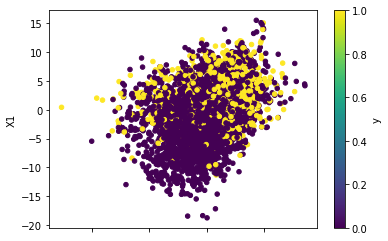

In [24]:
rp = GaussianRandomProjection(n_components=2, random_state=13)
X_rp = pd.DataFrame(rp.fit_transform(X_train), columns=["X1", "X2"])
X_rp = X_rp.assign(y = np.array(y_train))
all_2d = pd.concat([all_2d, X_rp.assign(algorithm = "rp")])
X_rp.plot.scatter(x='X2', y='X1', c='y', colormap='viridis')

In [52]:
reconstruction_errors = pd.DataFrame(columns=["n", "iter", "mean"])

for n in [2, 5, 10, 15, 20, 25, 30, 35, 40, 50]:
    diffs = list()
    for i in range(20):
        rp = GaussianRandomProjection(n_components=n)
        X_rp = pd.DataFrame(rp.fit_transform(X_train))
        mean = np.nanmean(np.square(X_train - np.dot(X_rp, rp.components_)))
        data = {"n" : n, "iter" : i, "mean" : mean}
        reconstruction_errors = reconstruction_errors.append(data, ignore_index=True)      

In [53]:
reconstruction_errors.to_csv("reconstruction_error_adult.csv", index=False)

In [25]:
cluster_error = pd.DataFrame(columns=["k", "n", "without_labels_mean",
                                      "without_labels_sd", "with_labels_mean",
                                      "with_labels_sd",
                                      "time", "avg_inertia",
                                      "homogeneity", "completeness",
                                      "v_measure", "adj_rand",
                                      "adj_mutual_info", "silhouette"])

kmeans = KMeans()
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=2000)

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]
n_range = [2, 3, 4, 5, 10, 20, 30]

for i, n in enumerate(n_range):
    X_rp = GaussianRandomProjection(random_state=i, n_components=n).fit_transform(X_train)
    for j, k in enumerate(k_range):
        # print(f"training {k}-means!")
        t0 = timeit.default_timer()
        kmeans = kmeans.set_params(n_clusters=k).fit(X_rp)
        labels = kmeans.labels_
        wo_labels_cv = cross_val_score(clf, X_rp, y_train)
        w_labels_cv = cross_val_score(clf,
                                      pd.DataFrame(X_rp).assign(labels=labels),
                                      y_train)
        
        scores = {"k": k,
                  "n": n,
                  "without_labels_mean": np.mean(wo_labels_cv),
                  "without_labels_sd": np.std(wo_labels_cv),
                  "with_labels_mean" : np.mean(w_labels_cv),
                  "with_labels_sd" : np.std(w_labels_cv),
                  "time" : timeit.default_timer() - t0,
                  "avg_inertia": kmeans.inertia_/len(X_train),
                  "homogeneity": metrics.homogeneity_score(y_train, labels),
                  "completeness" : metrics.completeness_score(y_train, labels),
                  "v_measure" : metrics.v_measure_score(y_train, labels),
                  "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
                  "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
                  "silhouette": metrics.silhouette_score(X_rp, labels,
                                                        metric='euclidean',
                                                        sample_size=300)
                 }
        cluster_error = cluster_error.append(scores, ignore_index=True)

all_dr_errors = pd.concat([cluster_error.assign(algorithm = "rp", clusterer = "kmeans"),
                           all_dr_errors])
cluster_error.sort_values(by = "adj_rand", ascending=False).head()

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,k,n,without_labels_mean,without_labels_sd,with_labels_mean,with_labels_sd,time,avg_inertia,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,silhouette
60,2.0,30.0,0.823142,0.013752,0.827589,0.008199,5.608040,44.436757,0.097994,0.084132,0.090535,0.167527,0.083999,0.111304
30,2.0,5.0,0.760001,0.002418,0.763703,0.002246,4.347880,40.851788,0.044087,0.036860,0.040151,0.084751,0.036725,0.233764
40,2.0,10.0,0.797958,0.010296,0.795737,0.009644,4.944481,41.781537,0.107894,0.085932,0.095669,0.070247,0.085809,0.158835
50,2.0,20.0,0.818883,0.013063,0.815553,0.007185,7.028819,43.915018,0.066331,0.052789,0.058790,0.056151,0.052662,0.107877
61,5.0,30.0,0.826663,0.010193,0.830367,0.007563,5.185919,37.434012,0.160320,0.058081,0.085270,0.044898,0.057851,0.095383


In [26]:
em_error = pd.DataFrame(columns=["k", "n", "time", "lower_bound",
                                 "without_labels_mean", "without_labels_sd",
                                 "with_labels_mean", "with_labels_sd",
                                 "homogeneity", "completeness",
                                 "v_measure", "adj_rand",
                                  "adj_mutual_info", "BIC", "silhouette"])

em = GaussianMixture()
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=2000)

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]
n_range = [2, 3, 4, 5, 10, 20, 30]

for i, n in enumerate(n_range):
    X_rp = GaussianRandomProjection(random_state=i, n_components=n).fit_transform(X_train)
    for j, k in enumerate(k_range):
        t0 = timeit.default_timer()
        em = em.set_params(n_components=k).fit(X_rp)
        labels = em.predict(X_rp)
        wo_labels_cv = cross_val_score(clf, X_ica, y_train)
        w_labels_cv = cross_val_score(clf,
                                      pd.DataFrame(X_rp).assign(labels=labels),
                                      y_train)

        scores = {"k": k,
                  "n": n,
                  "without_labels_mean": np.mean(wo_labels_cv),
                  "without_labels_sd": np.std(wo_labels_cv),
                  "with_labels_mean" : np.mean(w_labels_cv),
                  "with_labels_sd" : np.std(w_labels_cv),
                  "time" : timeit.default_timer() - t0,
                  "lower_bound": em.lower_bound_,
                  "homogeneity": metrics.homogeneity_score(y_train, labels),
                  "completeness" : metrics.completeness_score(y_train, labels),
                  "v_measure" : metrics.v_measure_score(y_train, labels),
                  "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
                  "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
                  "BIC" : em.bic(X_rp),
                  "silhouette": metrics.silhouette_score(X_rp, labels,
                                                        metric='euclidean',
                                                        sample_size=300)
                 }
        em_error = em_error.append(scores, ignore_index=True)

all_dr_errors = pd.concat([em_error.assign(algorithm = "rp", clusterer = "em"),
                           all_dr_errors])
em_error.head()

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,k,n,time,lower_bound,without_labels_mean,without_labels_sd,with_labels_mean,with_labels_sd,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,BIC,silhouette
0,2.0,2.0,6.203520,-5.951608,0.812948,0.037605,0.756295,0.002327,0.032417,0.030652,0.031510,-0.049382,0.030498,64365.666488,0.394929
1,5.0,2.0,10.754065,-5.947466,0.834811,0.007750,0.759629,0.002154,0.061539,0.022516,0.032969,0.009467,0.022276,64473.685014,0.269454
2,10.0,2.0,10.229560,-5.919405,0.836849,0.006653,0.758518,0.004245,0.063962,0.016658,0.026432,0.003862,0.016270,64429.273033,0.307374
3,15.0,2.0,8.498818,-5.907301,0.835553,0.005574,0.756666,0.002325,0.069990,0.015178,0.024946,0.002770,0.014674,64555.500886,0.303336
4,20.0,2.0,6.286463,-5.898038,0.836479,0.005746,0.758703,0.003995,0.072339,0.014004,0.023466,0.002802,0.013392,64713.096867,0.324422


# Truncated SVD

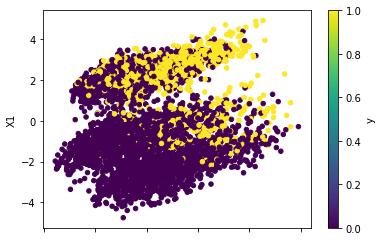

In [27]:
svd = TruncatedSVD(n_components=2)
X_svd = pd.DataFrame(svd.fit_transform(X_train, y_train), columns=["X1", "X2"])
X_svd = X_svd.assign(y = np.array(y_train))
all_2d = pd.concat([all_2d, X_svd.assign(algorithm = "svd")])
X_svd.plot.scatter(x='X2', y='X1', c='y', colormap='viridis')

In [28]:
cluster_error = pd.DataFrame(columns=["k", "n", "without_labels_mean",
                                      "without_labels_sd", "with_labels_mean",
                                      "with_labels_sd",
                                      "time", "avg_inertia",
                                      "homogeneity", "completeness",
                                      "v_measure", "adj_rand",
                                      "adj_mutual_info", "silhouette"])

kmeans = KMeans()
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=2000)

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]
n_range = [2, 3, 4, 5, 10, 20, 30]

for i, n in enumerate(n_range):
    X_svd = TruncatedSVD(random_state=i, n_components=n).fit_transform(X_train)
    for j, k in enumerate(k_range):
        # print(f"training {k}-means!")
        t0 = timeit.default_timer()
        kmeans = kmeans.set_params(n_clusters=k).fit(X_svd)
        labels = kmeans.labels_
        wo_labels_cv = cross_val_score(clf, X_svd, y_train)
        w_labels_cv = cross_val_score(clf,
                                      pd.DataFrame(X_svd).assign(labels=labels),
                                      y_train)
        
        scores = {"k": k,
                  "n": n,
                  "without_labels_mean": np.mean(wo_labels_cv),
                  "without_labels_sd": np.std(wo_labels_cv),
                  "with_labels_mean" : np.mean(w_labels_cv),
                  "with_labels_sd" : np.std(w_labels_cv),
                  "time" : timeit.default_timer() - t0,
                  "avg_inertia": kmeans.inertia_/len(X_train),
                  "homogeneity": metrics.homogeneity_score(y_train, labels),
                  "completeness" : metrics.completeness_score(y_train, labels),
                  "v_measure" : metrics.v_measure_score(y_train, labels),
                  "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
                  "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
                  "silhouette": metrics.silhouette_score(X_svd, labels,
                                                        metric='euclidean',
                                                        sample_size=300)
                 }
        cluster_error = cluster_error.append(scores, ignore_index=True)

all_dr_errors = pd.concat([cluster_error.assign(algorithm = "svd", clusterer = "kmeans"),
                           all_dr_errors])
cluster_error.sort_values(by = "adj_rand", ascending=False).head()

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,k,n,without_labels_mean,without_labels_sd,with_labels_mean,with_labels_sd,time,avg_inertia,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,silhouette
40,2.0,10.0,0.827777,0.006173,0.829258,0.004779,3.685595,17.744931,0.164420,0.134257,0.147815,0.197441,0.134138,0.191111
60,2.0,30.0,0.835924,0.005231,0.832218,0.009247,10.442481,39.187222,0.160574,0.131439,0.144553,0.197065,0.131320,0.090065
50,2.0,20.0,0.821472,0.020400,0.823886,0.007060,4.754479,29.342400,0.161348,0.131846,0.145113,0.195535,0.131726,0.122998
10,2.0,3.0,0.815740,0.004306,0.818332,0.004123,3.416333,6.101093,0.165844,0.134753,0.148691,0.191509,0.134635,0.365929
30,2.0,5.0,0.821482,0.001785,0.821668,0.004669,2.985268,10.297044,0.161696,0.131711,0.145171,0.191437,0.131592,0.261829


In [29]:
em_error = pd.DataFrame(columns=["k", "n", "time", "lower_bound",
                                 "without_labels_mean", "without_labels_sd",
                                 "with_labels_mean", "with_labels_sd",
                                 "homogeneity", "completeness",
                                 "v_measure", "adj_rand",
                                  "adj_mutual_info", "BIC", "silhouette"])

em = GaussianMixture()
clf = MLPClassifier(hidden_layer_sizes=(5), max_iter=2000)

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]
n_range = [2, 3, 4, 5, 10, 20, 30]

for i, n in enumerate(n_range):
    X_svd = TruncatedSVD(random_state=i, n_components=n).fit_transform(X_train)
    for j, k in enumerate(k_range):
        t0 = timeit.default_timer()
        em = em.set_params(n_components=k).fit(X_svd)
        labels = em.predict(X_svd)
        wo_labels_cv = cross_val_score(clf, X_svd, y_train)
        w_labels_cv = cross_val_score(clf,
                                      pd.DataFrame(X_svd).assign(labels=labels),
                                      y_train)

        scores = {"k": k,
                  "n": n,
                  "without_labels_mean": np.mean(wo_labels_cv),
                  "without_labels_sd": np.std(wo_labels_cv),
                  "with_labels_mean" : np.mean(w_labels_cv),
                  "with_labels_sd" : np.std(w_labels_cv),
                  "time" : timeit.default_timer() - t0,
                  "lower_bound": em.lower_bound_,
                  "homogeneity": metrics.homogeneity_score(y_train, labels),
                  "completeness" : metrics.completeness_score(y_train, labels),
                  "v_measure" : metrics.v_measure_score(y_train, labels),
                  "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
                  "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
                  "BIC" : em.bic(X_svd),
                  "silhouette": metrics.silhouette_score(X_svd, labels,
                                                        metric='euclidean',
                                                        sample_size=300)
                 }
        em_error = em_error.append(scores, ignore_index=True)

all_dr_errors = pd.concat([em_error.assign(algorithm = "svd", clusterer = "em"),
                           all_dr_errors])
em_error.head()

/Users/jonmcentee/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,k,n,time,lower_bound,without_labels_mean,without_labels_sd,with_labels_mean,with_labels_sd,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,BIC,silhouette
0,2.0,2.0,2.652057,-3.773016,0.806667,0.003549,0.813703,0.008245,0.156800,0.129555,0.141881,0.204348,0.129434,40842.493815,0.453035
1,5.0,2.0,2.536637,-3.652999,0.809814,0.007473,0.806853,0.002906,0.262066,0.090079,0.134074,0.076863,0.089869,39691.698778,0.394056
2,10.0,2.0,2.669362,-3.615941,0.815925,0.008959,0.806295,0.005219,0.291387,0.070925,0.114082,0.042609,0.070583,39552.735163,0.367280
3,15.0,2.0,2.844557,-3.627568,0.809071,0.007423,0.813147,0.007473,0.296666,0.064703,0.106236,0.009177,0.064222,39934.117825,0.412279
4,20.0,2.0,2.748891,-3.600500,0.812035,0.007560,0.813518,0.007209,0.308614,0.058486,0.098337,0.025061,0.057915,39900.213776,0.308359


In [30]:
all_dr_errors.to_csv("dim_reduction_adult.csv")
all_2d.to_csv("2d_adult.csv")